# Clustering-based anomaly detection
Name: Benjamin Fraeyman

In this part of the lab, you are given a dataset about the temperature in an office, measured over time. The goal is to find when the temperature in the office was abnormal, because for example the heating was malfunctioning.

In the previous two parts of the lab, you were asked to detect anomalies on datasets that were labeled. However, in real life, companies often have a vast amount of data available that is unfortunately **unlabeled**.
In such cases, the anomaly detection thus needs to be solved in an **unsupervised** way.

With this notebook, and the next one about the Matrix Profile, we want to demonstrate that anomaly detection can still be done unsupervised. In this notebook, we will use simple **clustering (k-means)**.

This assignment is based on https://www.kaggle.com/victorambonati/unsupervised-anomaly-detection/notebook (credit where credit is due). You *won't* find the answers to our questions over there, though. ;-)

In [1]:
# Import of all libraries that are going to be used:
# For data processing:
import pandas as pd
import numpy as np

# For data visualization:
import matplotlib
import matplotlib.dates as md
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
%matplotlib notebook

# For machine learning:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# to clear output after long list of checks that were printed out :)
from IPython.display import clear_output # used in last codeblock to remove all the prints from my functions

# 1. Data analysis

The data you'll be working with, is about temperatures in an office. It is one of the datasets of the Numenta Anomaly Benchmark (NAB, https://github.com/numenta/NAB).

In [2]:
# Reading the data:
data = pd.read_csv("ambient_temperature_system_failure.csv")

We must understand what the data represents to be able to work with it, of course. Let's check what columns are available, and how much data points:

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 2 columns):
timestamp    7267 non-null object
value        7267 non-null float64
dtypes: float64(1), object(1)
memory usage: 113.6+ KB


We are also interested in:

- the format of the timestamps, and at what frequency the office temperatures have been measured,
- how the temperature values are expressed.

We can check this by printing the first and last 10 rows in the dataset:

In [4]:
display(data.head(10))
display(data.tail(10))

,timestamp,value
0,2013-07-04 00:00:00,69.880835
1,2013-07-04 01:00:00,71.220227
2,2013-07-04 02:00:00,70.877805
3,2013-07-04 03:00:00,68.959400
4,2013-07-04 04:00:00,69.283551
5,2013-07-04 05:00:00,70.060966
6,2013-07-04 06:00:00,69.279765
7,2013-07-04 07:00:00,69.369608
8,2013-07-04 08:00:00,69.166714
9,2013-07-04 09:00:00,68.986083


,timestamp,value
7257,2014-05-28 06:00:00,64.784023
7258,2014-05-28 07:00:00,65.645874
7259,2014-05-28 08:00:00,67.472568
7260,2014-05-28 09:00:00,68.033080
7261,2014-05-28 10:00:00,70.455717
7262,2014-05-28 11:00:00,72.370206
7263,2014-05-28 12:00:00,72.172956
7264,2014-05-28 13:00:00,72.046565
7265,2014-05-28 14:00:00,71.825226
7266,2014-05-28 15:00:00,72.584089


It's clear that the temperatures were measured every hour, from the 4th of July 2013 until the 28th of May 2014.

The temperature values are certainly not in degrees Celsius. Since we know the temperatures were measured in an office, the average of the measured temperature values will probably around room temperature - unless the office was abandoned for some reason.

In [5]:
data['value'].mean()

71.2424327082882

This average temperature must have been measured in Fahrenheit, if it represents room temperature (see
https://en.wikipedia.org/wiki/Scale_of_temperature#Conversion_table_between_different_temperature_scales).
How much would the average temperature have been in the office, in Celcius?

In [6]:
avg_temperature_celcius = (data['value'].mean() - 32) * 5/9
print(avg_temperature_celcius)

21.80135150460456


Good - the employees in the office will have felt comfortable. On average. 

This average is calculated over *all* temperature measurements, even those at night. Most probably this means it's warmer during the day for the office workers, and the office does not cool down a lot at night.

But it's possible that there were some anomalous temperatures that the employees had to endure. Curious? Let's find out in this lab.

The following plot already visualizes all temperatures measured in the office. It's clear that there may have been some abnormal temperatures in this office. Notice the peak in the middle of the plot for example.

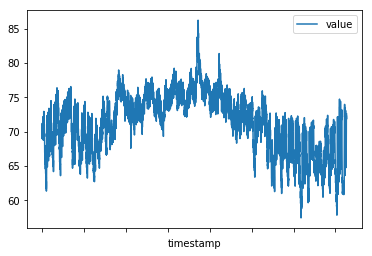

In [7]:
data.plot(x='timestamp', y='value')
data.show()

The temperatures are still in Fahrenheit on the plot, and the X axis doesn't plot the dates well, since their datatype is still 'object'. Some preprocessing is required.

# 2. Data preprocessing

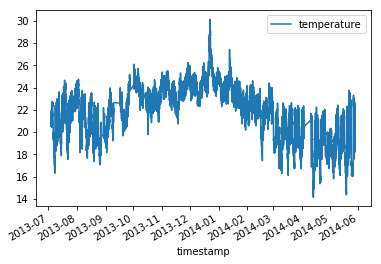

In [8]:
# Change the data type for the timestamp column for plotting:
data['timestamp'] = pd.to_datetime(data['timestamp'])
# Value column contains temperatures in Fahrenheit (mean = 71), converting to Celcius:
data['temperature'] = (data['value'] - 32) * 5/9
# Redrawing the plot:
data.plot(x='timestamp', y='temperature')
data.show()

# 3. Feature extraction

The office temperature fluctuated a lot on the line chart above. But that's OK, since probably the office is only heated during the day and cools down at night. And in the weekend, the office heating will be switched off too. The situation would've been different for the temperature in a factory that has employees working 24/7.

You could've flagged each extreme high or low temperature on the line chart as an anomaly. But now we know, for example, that a lot of low temperatures will just be 'normal', since these temperatures will probably just have been measured at night or in weekends.
So it is interesting to flag temperatures as abnormal (anomalous) if they are **not normal within their situation**. And therefore, it is a good idea to **cluster** the data into patterns (working modes in the office, in this case: weekday/weekend, day/night). **An anomalous temperature will then be distant from the cluster center**, i.e. the average temperature for that working mode.

To help the clustering method see the pattern in the data, there must be a data value that occurs again and again. This is not the case if we would present the clustering method a column of datetimes. But if we give it a column that says if the datapoint is a weekday or a weekend day, the clustering method will detect re-occurring data values. So let's do some feature extraction.

In [9]:
# the hours and if it's night or day (7:00-22:00)
data['hour'] = data['timestamp'].dt.hour
data['daylight'] = ((data['hour'] >= 7) & (data['hour'] <= 22)).astype(int)
# the day of the week (Monday=0, Sunday=6) and if it's a weekend day or week day.
data['day_of_the_week'] = data['timestamp'].dt.dayofweek
data['weekday'] = (data['day_of_the_week'] < 5).astype(int)
# time expressed as an integer to plot easily
data['time_epoch'] = (data['timestamp'].astype(np.int64)/100000000000).astype(np.int64)

# 4. Model: clustering the data with k-means

We determined (with Principal Component Analysis, outside the scope of this course) that **the most important features in the data are weekday, hour and temperature.**

Let's first visualize the data in terms of these 3 features:

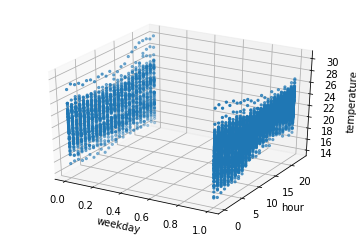

In [10]:
from mpl_toolkits.mplot3d import Axes3D

def show_data_3d(data, column_for_x, column_for_y, column_for_z, color_by_cluster=False, column_for_cluster=None, anomalies=None):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    if color_by_cluster:
        ax.scatter(xs=data[column_for_x], ys=data[column_for_y], zs=data[column_for_z], marker='.', c=data[column_for_cluster])
    else:
        ax.scatter(xs=data[column_for_x], ys=data[column_for_y], zs=data[column_for_z], marker='.')
    ax.set_xlabel(column_for_x)
    ax.set_ylabel(column_for_y)
    ax.set_zlabel(column_for_z)
    if anomalies is not None:
        ax.scatter(xs=anomalies[column_for_x], ys=anomalies[column_for_y], zs=anomalies[column_for_z], c='red', marker='o')
    plt.show()
    
show_data_3d(data, column_for_x='weekday', column_for_y='hour', column_for_z='temperature')

We can distinguish that if we would make a cluster for weekdays (left on the plot above) and for weekend days (right), we could calculate the outliers in that cluster as those data points that deviate most from the cluster center.

So let's first cluster the data points, using the most basic and popular algorithm, k-means:

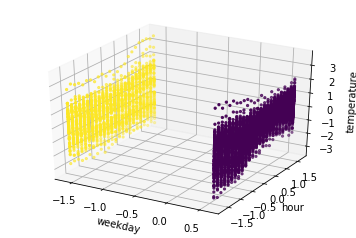

In [11]:
columns_to_cluster = ['weekday', 'hour', 'temperature']

znorm_scaler = StandardScaler()
data_to_cluster = pd.DataFrame(znorm_scaler.fit_transform(data[columns_to_cluster]), columns=columns_to_cluster)

kmeans = KMeans(n_clusters=2)
kmeans.fit(data_to_cluster)

clustered_data = data_to_cluster.copy() # we're going to add columns to the data, if we do this on the original data, we will not be able to re-execute the clustering
clustered_data['cluster'] = kmeans.predict(data_to_cluster)
show_data_3d(clustered_data, column_for_x='weekday', column_for_y='hour', column_for_z='temperature',
            color_by_cluster=True, column_for_cluster='cluster')

Let's now calculate the distances of all points to the centroid of their assigned cluster.

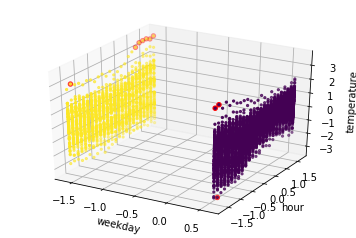

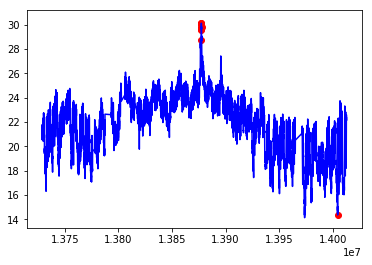

,timestamp,value,temperature,hour,daylight,day_of_the_week,weekday,time_epoch,anomalous,cluster
3702,2013-12-22 01:00:00,83.780995,28.767219,1,0,6,0,13876740,True,1
3719,2013-12-22 18:00:00,85.227685,29.570936,18,1,6,0,13877352,True,1
3720,2013-12-22 19:00:00,86.094888,30.052716,19,1,6,0,13877388,True,1
3721,2013-12-22 20:00:00,86.204189,30.113438,20,1,6,0,13877424,True,1
3722,2013-12-22 21:00:00,86.223213,30.124007,21,1,6,0,13877460,True,1
3723,2013-12-22 22:00:00,85.649437,29.805243,22,1,6,0,13877496,True,1
3724,2013-12-22 23:00:00,86.074710,30.041505,23,0,6,0,13877532,True,1
3725,2013-12-23 00:00:00,85.326165,29.625647,0,0,0,1,13877568,True,0
3726,2013-12-23 01:00:00,85.705990,29.836661,1,0,0,1,13877604,True,0
7036,2014-05-19 01:00:00,57.861906,14.367725,1,0,0,1,14004612,True,0


In [12]:
dists_to_centroids = kmeans.transform(data_to_cluster)
clustered_data['dist_to_closest_centroid'] = np.min(dists_to_centroids, axis=1)
# Find the 10 most anomalous data points:
anomalies = clustered_data.sort_values('dist_to_closest_centroid', ascending=False)[0:10]
data_anomalousness = np.zeros((data.shape[0], 1), dtype=bool)
data_anomalousness[anomalies.index, 0] = True
data['anomalous'] = data_anomalousness

# Visualize the anomalies, both in feature space and time space:

# -> in feature space:
data['cluster'] = clustered_data['cluster']
show_data_3d(clustered_data, column_for_x='weekday', column_for_y='hour', column_for_z='temperature',
            color_by_cluster=True, column_for_cluster='cluster',
            anomalies=anomalies)

# -> in time space:
def show_data_over_time(data, time_column, data_column, anomalies=None):
    fig, ax = plt.subplots()
    ax.plot(data[time_column], data[data_column], color='blue')
    if anomalies is not None:
        ax.scatter(anomalies[time_column], anomalies[data_column], color='red')
    plt.show()

show_data_over_time(data, time_column='time_epoch', data_column='temperature', anomalies=data[data['anomalous']==True])

display(data[data['anomalous']==True])

# 5. Model evaluation

The data for this assignment was taken from the Numenta Anomaly Benchmark (NAB).

At the start of the lab we said that the majority of datasets produced by sensors in the industry are not labeled, making anomaly detection problems on it unsupervised, which was why clustering-based anomaly detection was an option.

However, this dataset actually does provide labels (the ground truth). It determines a datapoint as anomalous when it was the first measurement made during a system failure (i.e. the office heating was down). The anomalous temperatures are thus said to be measured at 2013-12-22 20:00 and 2014-04-13 09:00.

*Knowing this, please compute how much true positives (TP), false positives (FP), true negatives (TN) and false negatives (FN) were outputted by the above k-means model.*

**Do NOT modify the variable names that we prepared for you!! We will use them for automatically grading this lab.**

Sources: 
> https://stackoverflow.com/questions/17071871/select-rows-from-a-dataframe-based-on-values-in-a-column-in-pandas
https://towardsdatascience.com/pandas-tips-and-tricks-33bcc8a40bb9

In [13]:
display(data.loc[data['timestamp'] == "2013-12-22 20:00"])
display(data.loc[data['timestamp'] == "2014-04-13 09:00"])
known_positives = [pd.to_datetime("2013-12-22 20:00"), pd.to_datetime("2014-04-13 09:00")]

def check_TP_FP(df):
    TP = 0
    FP = 0
    for index, row in df.loc[df['anomalous'] == True].iterrows():
        done = False
        for i in range(0, len(known_positives)):
            if row['timestamp'] == known_positives[i]:
                print("TP:", row['timestamp'], "-", known_positives[i])
                TP = TP + 1
                done = True
        if done == False:
            FP = FP + 1
        else: done = False
    return TP, FP

def check_TN_FN(df):
    TN = 0
    FN = 0
    for index, row in df.loc[df['anomalous'] == False].iterrows():
        done = False
        for i in range(0, len(known_positives)):
            if row['timestamp'] == known_positives[i]:
                print("FN:", row['timestamp'], "-", known_positives[i])
                FN = FN + 1
                done = True
        if done == False:
            TN = TN + 1
        else: done = False
    return TN, FN

num_TP, num_FP = check_TP_FP(data)
num_TN, num_FN = check_TN_FN(data)
# num_TP = check_TP_FP(data)[0]
# num_FP = check_TP_FP(data)[1]
# num_TN = check_TN_FN(data)[0]
# num_FN = check_TN_FN(data)[1]
# raise NotImplementedError
clear_output(wait=True)
print('TP:', num_TP)
print('FP:', num_FP)
print('TN:', num_TN)
print('FN:', num_FN)

TP: 1
FP: 9
TN: 7256
FN: 1


Up til now, the top 10 anomalies were calculated and the number of true positives and so on were printed.

However, by making the model flag only the 10 most distant points as anomalies, only 1 true positive was achieved, while actually we know there are 2 anomalies.

*Now please complete the code of the following code skeleton, in order to find the 2 known anomalies.*

**Again, keep the x variable in the code below, so we can automatically grade this lab.**

In [14]:
def find_top_x_anomalies(clustered_data, x):
    dists_to_centroids = kmeans.transform(data_to_cluster)
    clustered_data['dist_to_closest_centroid'] = np.min(dists_to_centroids, axis=1)
    # Find the x most anomalous data points:
    anomalies = clustered_data.sort_values('dist_to_closest_centroid', ascending=False)[0:x]
    data_anomalousness = np.zeros((data.shape[0], 1), dtype=bool)
    data_anomalousness[anomalies.index, 0] = True
    data['anomalous'] = data_anomalousness
#     raise NotImplementedError # Look above for inspiration. This function should write to clustered_data['anomalous'].

def evaluate_model(data):
    num_TP, num_FP = check_TP_FP(data)
    num_TN, num_FN = check_TN_FN(data)
#     raise NotImplementedError # Calculate num_TP, num_FP, num_TN, num_FN, based on data['anomalous'] and data['timestamp'].
    return num_TP, num_FP, num_TN, num_FN

def find_x():
    for x in range(10, 100, 1):
        find_top_x_anomalies(clustered_data, x)
        TP, FP, TN, FN = evaluate_model(data)
        if TP == 2:
            clear_output(wait=True)
            print('x:', x)
            print('TP:', TP)
            print('FP:', FP)
            print('TN:', TN)
            print('FN:', FN)
            return x, TP, FP, TN, FN

x, TP, FP, TN, FN = find_x()

x: 44
TP: 2
FP: 42
TN: 7223
FN: 0


So, this time all known anomalies were found, but at the cost of some false predictions.

This concludes this part of the lab. In the next part, you'll be introduced to another unsupervised anomaly detection technique, the matrix profile.